<a href="https://colab.research.google.com/github/why-arong/fake-voice-detection/blob/mel-resnet/ssl_unlabeled_mel_resnet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data

In [1]:
# !wget 'https://drive.usercontent.google.com/download?id=1HLBDBTnrLvVdqXxMQTDJyTUf5ryBqcxD&export=download&authuser=1&confirm=t' -O open.zip

In [21]:
# !unzip -q open.zip

[open.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of open.zip or
        open.zip.zip, and cannot find open.zip.ZIP, period.


In [1]:
!pip3 install torchsummary


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip3 install torch


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip3 install torchaudio


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip3 install librosa


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


# Import libraries and setting

In [5]:
import os
import random
import math

import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# import torchaudio
import torchaudio.transforms as T

import librosa

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [6]:
SR = 32000
SEED = 1
BS = 4

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Define dataset and augmetation pipeline

In [8]:
def convert_to_fixed_length(audio, fixed_len):
    audio = audio.unsqueeze(0)

    # print(audio.shape)
    _, length = audio.shape

    if length < fixed_len:
        to_pad = fixed_len - length
        left_pad = torch.randint(0, to_pad + 1, (1,)).item()
        right_pad = to_pad - left_pad
        audio = torch.nn.functional.pad(audio, (left_pad, right_pad), mode='constant', value=0)
    else:
        start = torch.randint(0, length - fixed_len + 1, (1,)).item()
        audio = audio[:, start:start + fixed_len]

    return audio


class AudioDataset(Dataset):
    def __init__(self, data_paths, labels, unlabeled_paths, fixed_len=SR*4):
        self.data_paths = data_paths
        self.labels = labels
        self.unlabeled_paths = unlabeled_paths
        self.fixed_len = fixed_len

        self.data_length = len(data_paths)
        self.unlabeled_length = len(unlabeled_paths)

    def __len__(self):
        return self.data_length

    def __getitem__(self, idx):
        rand_val = random.random()

        if rand_val <= 0.15:
            wave = torch.zeros(1, self.fixed_len)
            merged_label = (0, 0)

        elif rand_val <= 0.3:
            path, label = self.data_paths[idx], self.labels[idx]
            wave, _ = librosa.load(path, sr=SR)
            
            wave = torch.tensor(wave).float()

            wave = convert_to_fixed_length(wave, self.fixed_len)
            merged_label = (0, 1) if label else (1, 0)

        elif rand_val <= 0.6:
            rand_idx = np.random.randint(0, self.data_length)
            path1, label1 = self.data_paths[idx], self.labels[idx]
            path2, label2 = self.data_paths[rand_idx], self.labels[rand_idx]

            wave1, _ = librosa.load(path1, sr=SR)
            wave2, _ = librosa.load(path2, sr=SR)

            wave1 = torch.tensor(wave1).float()
            wave2 = torch.tensor(wave2).float()

            wave1 = convert_to_fixed_length(wave1, self.fixed_len)
            wave2 = convert_to_fixed_length(wave2, self.fixed_len)

            wave = (wave1 + wave2) / 2
            merged_label = (int(label1 == 0 or label2 == 0), int(label1 == 1 or label2 == 1))

        else:
            rand_idx = np.random.randint(0, self.unlabeled_length)
            path1, label = self.data_paths[idx], self.labels[idx]
            path2 = self.unlabeled_paths[rand_idx]

            wave1, _ = librosa.load(path1, sr=SR)
            wave2, _ = librosa.load(path2, sr=SR)

            wave1 = torch.tensor(wave1).float()
            wave2 = torch.tensor(wave2).float()

            wave1 = convert_to_fixed_length(wave1, self.fixed_len)
            wave2 = convert_to_fixed_length(wave2, self.fixed_len)

            wave = (wave1 + wave2) / 2
            merged_label = (0.5, 1) if label else (1, 0.5)
        wave = torch.tensor(wave).float()
        label = torch.tensor(merged_label).float()
        return wave, label

In [9]:
class AudioPipeline(nn.Module):
    def __init__(self, on_train=True, noise_level=0.1):
        super().__init__()
        self.on_train = on_train
        self.noise_level = noise_level

        self.spec_250 = self.create_spec(250)
        self.spec_500 = self.create_spec(500)
        self.spec_750 = self.create_spec(750)
        self.spec_1000 = self.create_spec(1000)

        self.spec_aug = nn.Sequential(
            T.FrequencyMasking(20),
            T.TimeMasking(10),
            T.TimeMasking(10),
        )

    def create_spec(self, win_length):
        return nn.Sequential(
            T.MelSpectrogram(
                sample_rate=SR,
                n_fft=2048,
                win_length=win_length,
                hop_length=500,
                n_mels=128
            ),
            T.AmplitudeToDB()
        )

    def forward(self, wave):
        with torch.no_grad():
            if self.on_train:
                noise = torch.randn_like(wave) * self.noise_level
                wave = wave + noise

            spec0 = self.spec_250(wave)
            spec1 = self.spec_500(wave)
            spec2 = self.spec_750(wave)
            spec3 = self.spec_1000(wave)
            specs = torch.cat([spec0, spec1, spec2, spec3], dim=1)[:, :, :, :-1]

            if self.on_train:
                specs = self.spec_aug(specs)

            specs = self.normalize(specs)
        return specs

    def normalize(self, spec, epsilon=1e-6):
        mean = spec.mean(dim=[2, 3], keepdim=True)
        std = spec.std(dim=[2, 3], keepdim=True)
        return (spec - mean) / (std + epsilon)

    def train(self):
        self.on_train = True

    def eval(self):
        self.on_train = False

In [12]:
train = pd.read_csv("train.csv")
train["label"] = train["label"].apply(lambda x: 1 if x == "real" else 0)
train.head()

,id,path,label
0,RUNQPNJF,./train/RUNQPNJF.ogg,1
1,JFAWUOGJ,./train/JFAWUOGJ.ogg,0
2,RDKEKEVX,./train/RDKEKEVX.ogg,1
3,QYHJDOFK,./train/QYHJDOFK.ogg,1
4,RSPQNHAO,./train/RSPQNHAO.ogg,1


In [13]:
unlabeled_folder = "./unlabeled_data"
unlabeled_paths = [os.path.join(unlabeled_folder, file_path) for file_path in os.listdir(unlabeled_folder)]
unlabeled_paths[:5]

['./unlabeled_data/WXTZHVXY.ogg',
 './unlabeled_data/KWLUVSUZ.ogg',
 './unlabeled_data/JXQTQJGY.ogg',
 './unlabeled_data/AVDRWFTZ.ogg',
 './unlabeled_data/KXXLKOGQ.ogg']

In [14]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train["path"].values, train["label"].values, test_size=0.2, stratify=train["label"]
)

train_dataset = AudioDataset(train_paths, train_labels, unlabeled_paths)
valid_dataset = AudioDataset(valid_paths, valid_labels, unlabeled_paths)

train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BS, shuffle=False)

audio_pipeline = AudioPipeline().to(device)

# Define model

In [15]:
!pip3 install -U flash-attn --no-build-isolation


  Using cached flash_attn-2.6.1.tar.gz (2.6 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [12 lines of output]
      fatal: not a git repository (or any of the parent directories): .git
      
      
      torch.__version__  = 2.3.1+cu121
      
      
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-nqytcn1s/flash-attn_d12e49b28b574405b40dfcab15eaaeb6/setup.py", line 115, in <module>
          raise RuntimeError(
      RuntimeError: FlashAttention is only supported on CUDA 11.6 and above.  Note: make sure nvcc has a supported version by running nvcc -V.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package

In [14]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# Processor 및 모델 로드
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec2_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

processor.feature_extractor.sampling_rate = SR
wav2vec2_model.config.sampling_rate = SR


/home/haaaa/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/haaaa/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/haaaa/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav

In [15]:
import torch.nn as nn

class AudioClassifier(nn.Module):
    def __init__(self, wav2vec2_model, num_labels):
        super(AudioClassifier, self).__init__()
        self.wav2vec2 = wav2vec2_model
        # print("wav2vec2 config ---------------------")
        # print(self.wav2vec2.config)
        self.classifier = nn.Linear(self.wav2vec2.config.hidden_size, num_labels)

    def forward(self, input_values):
        outputs = self.wav2vec2(input_values).last_hidden_state
        # 시퀀스의 첫 번째 토큰의 출력을 사용 (또는 mean pooling 등)
        pooled_output = outputs.mean(dim=1)
        logits = self.classifier(pooled_output)
        # print("logits :", logits)
        return logits

audio_pipeline = AudioClassifier(wav2vec2_model, num_labels=2).to(device)


In [18]:
import torch.optim as optim
from tqdm import tqdm

# 손실 함수 및 옵티마이저 설정
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(audio_pipeline.parameters(), lr=5e-5)

# 학습 함수
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for speeches, labels in tqdm(dataloader):
        inputs = processor(speeches, sampling_rate=SR, return_tensors="pt", padding=True).input_values.to(device)
        inputs = inputs.squeeze()  # [batch_size, sequence_length]로 변환
        labels = torch.tensor(labels).float().to(device)
        optimizer.zero_grad()
        # print("inputs -----------------")
        # print(inputs.shape)
        outputs = model(inputs)
        # print(outputs.shape)
        # print(outputs)
        # print(labels.shape)
        # print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# 평가 함수
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for speeches, labels in tqdm(dataloader):
            inputs = processor(speeches, sampling_rate=SR, return_tensors="pt", padding=True).input_values.to(device)
            inputs = inputs.squeeze()  # [batch_size, sequence_length]로 변환
            labels = torch.tensor(labels).float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)


In [19]:

# 학습 및 평가 루프
num_epochs = 3
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    train_loss = train(audio_pipeline, train_dataloader, criterion, optimizer, device)
    valid_loss = evaluate(audio_pipeline, valid_dataloader, criterion, device)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # 최상의 모델 저장
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(audio_pipeline.state_dict(), 'best_audio_pipeline.pt')

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {valid_loss}")


  0%|          | 0/11088 [00:00<?, ?it/s]/tmp/ipykernel_18359/2159105451.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wave = torch.tensor(wave).float()
/tmp/ipykernel_18359/2159105451.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wave = torch.tensor(wave).float()
2024-07-19 01:34:00.492500: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 01:34:00.518058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factor

Epoch 1/3, Train Loss: 0.6708119078492275, Validation Loss: 0.671300904016302


100%|██████████| 2772/2772 [05:13<00:00,  8.85it/s]


Epoch 2/3, Train Loss: 0.6738962174257502, Validation Loss: 0.6740125173227095


  5%|▌         | 591/11088 [03:14<57:30,  3.04it/s]  


KeyboardInterrupt: 

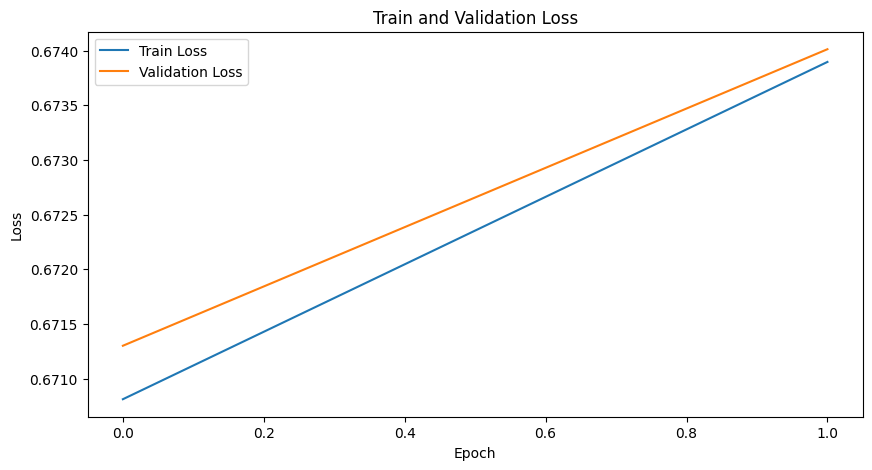

In [20]:

# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Inference

In [16]:
class TestAudioDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.length = len(file_paths)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        wave, _ = librosa.load(self.file_paths[index], sr=SR)
        wave = torch.tensor(wave).float()
        wave = wave.unsqueeze(0)
        start_idx = int(0.5 * SR)
        end_idx = int(4.5 * SR)
        wave = wave[:, start_idx:end_idx]
        return wave

In [17]:
test = pd.read_csv("test.csv")
test_dataset = TestAudioDataset(test["path"].values)
test_dataloader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

In [19]:

# 최상의 모델 로드
best_model = AudioClassifier(wav2vec2_model, num_labels=2).to(device)
best_model.load_state_dict(torch.load('best_audio_pipeline.pt'))
best_model.eval()

# 테스트 데이터셋에 대한 예측 수행
preds = []
for waves in tqdm(test_dataloader):
    inputs = processor(waves, sampling_rate=SR, return_tensors="pt", padding=True).input_values.to(device)
    inputs = inputs.squeeze()  # [batch_size, sequence_length]로 변환
    outputs = best_model(inputs)
    pred = torch.sigmoid(outputs).detach().cpu().numpy()
    preds += pred.tolist()


100%|██████████| 12500/12500 [23:03<00:00,  9.04it/s]


In [22]:
submit = pd.read_csv("sample_submission.csv")
submit.iloc[:, 1:] = preds
submit.to_csv("ssl_unlabeled_mel_wav2vec2_2ep.csv", index=False)

In [23]:
submit.head()

,id,fake,real
0,TEST_00000,0.629356,0.590382
1,TEST_00001,0.629356,0.590382
2,TEST_00002,0.629356,0.590382
3,TEST_00003,0.629356,0.590382
4,TEST_00004,0.629356,0.590382


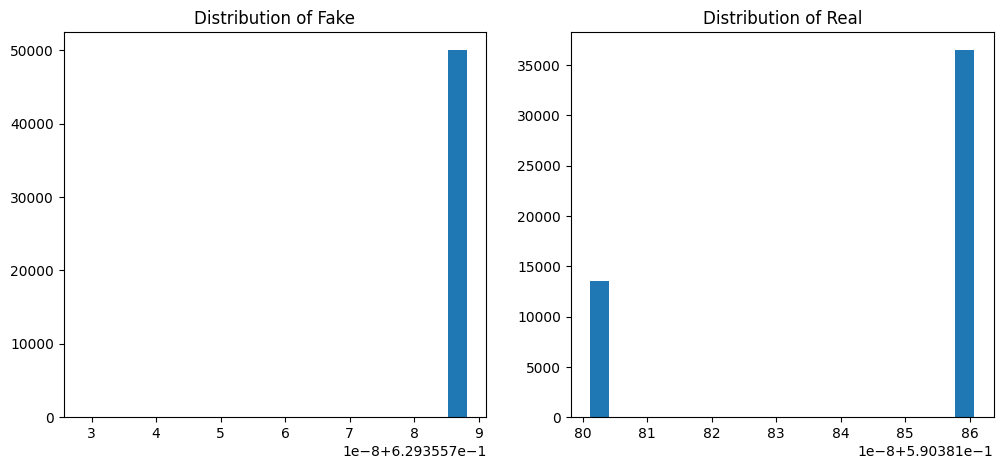

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Distribution of Fake")
plt.hist(submit["fake"], bins=20)

plt.subplot(1, 2, 2)
plt.title("Distribution of Real")
plt.hist(submit["real"], bins=20)
plt.show()